## download photo dataset

In [1]:
# download and explore unsplash dataset
import pandas as pad
from os.path import join, exists
import urllib.request
import os
from multiprocessing import Pool


unsplash_root = "/home/agent_h/data/unsplash-research-dataset-lite-latest/"
photo_export_path = join(unsplash_root,"photos")
os.makedirs(photo_export_path,exist_ok=True)

# Read the photos table
photos = pd.read_csv(join(unsplash_root,"photos.tsv000"), sep='\t', header=0)
# Extract the IDs and the URLs of the photos
photo_urls = photos[['photo_id', 'photo_image_url']].values.tolist()
# Print some statistics
print(f'Photos in the dataset: {len(photo_urls)}')


# Function that downloads a single photo
def download_photo(photo):
    photo_id = photo[0]
    photo_url = photo[1]
    # Path where the photo will be stored
    photo_path = join(photo_export_path,photo_id+".jpg")
    # Only download a photo if it doesn't exist
    if not exists(photo_path):
        try:
            urllib.request.urlretrieve(photo_url, photo_path)
        except:
            print(f"Cannot download {photo_url}")
            pass

# download
p = Pool(6)
p.map(download_photo, photo_urls)

Photos in the dataset: 25000


## process all images

In [ ]:
from glob import glob
from os.path import join, basename
import cv2
from tqdm import tqdm
from multiprocessing import Pool
import os

n_proc = 128
photos_path = "/home/agent_h/data/unsplash-research-dataset-lite-latest/photos/"
photos_export = "/home/agent_h/data/unsplash-research-dataset-lite-latest/photos_640/"

def resize_photo(photo):
    try:
        photos_path = "/home/agent_h/data/unsplash-research-dataset-lite-latest/photos/"
        photos_export = "/home/agent_h/data/unsplash-research-dataset-lite-latest/photos_640/"
        os.makedirs(photos_export,exist_ok=True)
        img = cv2.imread(photo)
        img = cv2.resize(img, (640, int(640/img.shape[1]*img.shape[0])))
        cv2.imwrite(join(photos_export,photo.split("/")[-1]),img)
    except:
        print("failed")

photo_paths = glob(join(photos_path,"*.jpg"))
print(f"Photos found: {len(photo_paths)}")

if n_proc == 1:
    # resize to 640w and save
    for photo in tqdm(photo_paths[:10]):
        img = cv2.imread(photo)
        img = cv2.resize(img, (640, int(640/img.shape[1]*img.shape[0])))
        cv2.imwrite(join(photos_export,photo.split("/")[-1]),img)

else:
    p = Pool(n_proc)
    for _ in tqdm(p.imap_unordered(resize_photo, photo_paths), total=len(photo_paths)):
        pass
    



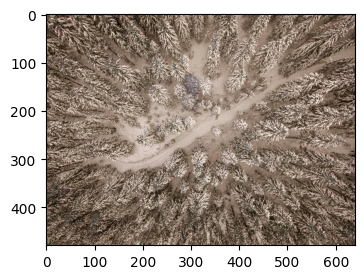

In [8]:
from glob import glob
from os.path import join
import cv2
from tqdm import tqdm
import ht2
import numpy as np
import matplotlib.pyplot as plt

def show_img_np(img, max_h=3, max_w=20, save=False, cmap='gray'):
    """
    :param np_array: input image, one channel or 3 channel,
    :param save: if save image
    :param size:
    :return:
    """
    if len(img.shape) < 3:
        plt.rcParams['image.cmap'] = cmap
    plt.figure(figsize=(max_w, max_h), facecolor='w', edgecolor='k')
    plt.imshow(img)
    if save:
        cv2.imwrite('debug.png', img)
    else:
        plt.show()

photos_export = "/home/agent_h/data/unsplash-research-dataset-lite-latest/photos_640/"
photo_paths = glob(join(photos_export,"*.jpg"))
img = cv2.imread(photo_paths[0])
show_img_np(img)

## CLIP

In [3]:
import clip
import torch
from PIL import Image

# Load the open CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Function that computes the feature vectors for a batch of images
def compute_clip_features(photos_batch):
    # Load all the photos from the files
    photos = [Image.open(photo_file) for photo_file in photos_batch]
    
    # Preprocess all photos
    photos_preprocessed = torch.stack([preprocess(photo) for photo in photos]).to(device)

    with torch.no_grad():
        # Encode the photos batch to compute the feature vectors and normalize them
        photos_features = model.encode_image(photos_preprocessed)
        photos_features /= photos_features.norm(dim=-1, keepdim=True)

    # Transfer the feature vectors back to the CPU and convert to numpy
    return photos_features.cpu().numpy()

## prerun features for all images

In [6]:
import math
import numpy as np
import pandas as pd
import os
from glob import glob
from os.path import join,exists
from tqdm import tqdm


# Define the batch size so that it fits on your GPU. You can also do the processing on the CPU, but it will be slower.
batch_size = 256

# Path where the feature vectors will be stored
features_path = "/home/agent_h/data/unsplash-research-dataset-lite-latest/features/"
os.makedirs(features_path,exist_ok=True)

photos_path = "/home/agent_h/data/unsplash-research-dataset-lite-latest/photos_640/"
photo_paths = glob(join(photos_path,"*.jpg"))
print(f"Photos found: {len(photo_paths)}")



photos_files = photo_paths
# Compute how many batches are needed
batches = math.ceil(len(photos_files) / batch_size)

# Process each batch
for i in tqdm(range(batches)):

    batch_ids_path = join(features_path,f"{i:010d}.csv")
    batch_features_path = join(features_path,f"{i:010d}.npy")
    
    # Only do the processing if the batch wasn't processed yet
    if not exists(batch_features_path):
        # try:
        # Select the photos for the current batch
        batch_files = photos_files[i*batch_size : (i+1)*batch_size]

        # Compute the features and save to a numpy file
        batch_features = compute_clip_features(batch_files)
        np.save(batch_features_path, batch_features)

        # Save the photo IDs to a CSV file
        photo_ids = [photo_file.split(".")[0] for photo_file in batch_files]
        photo_ids_data = pd.DataFrame(photo_ids, columns=['photo_id'])
        photo_ids_data.to_csv(batch_ids_path, index=False)
        # except:
            # Catch problems with the processing to make the process more robust
            # print(f'Problem with batch {i}')

Photos found: 24844


100%|█████████████████████████████████████████████████████████████████████████████████████| 98/98 [03:03<00:00,  1.88s/it]


In [10]:
import numpy as np
import pandas as pd

# Load all numpy files
features_list = [np.load(features_file) for features_file in sorted(glob(join(features_path,"*.npy")))]

# Concatenate the features and store in a merged file
features = np.concatenate(features_list)
np.save(join(features_path,"features.npy"), features)

# Load all the photo IDs
photo_ids = pd.concat([pd.read_csv(ids_file) for ids_file in sorted(glob(join(features_path,"*.csv")))])
photo_ids.to_csv(join(features_path,"photo_ids.csv"), index=False)